In [1]:
# Adicione isso junto com os outros imports
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

# bibliotecas para treino, teste e validação, modelo de regressão e avaliação do modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# bibliotecas para avaliação de desempenho dos modelos de classificação
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import clone

In [2]:
BASE_PATH = "/kaggle/input/the-oxford-iii-t-pet-dataset/" 
IMAGES_PATH = os.path.join(BASE_PATH, "images/images")
ANNOTATIONS_PATH = os.path.join(BASE_PATH, "annotations/annotations")

IMG_SIZE = (128, 128)

In [3]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle

def load_data_complete(folder_path, img_size=(128, 128)):
    X = []
    y_especie = [] # 0: Gato, 1: Cachorro
    y_raca = []
    
    print("Carregando imagens e extraindo raças...")
    
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                
                if filename[0].islower():
                    label = 1 
                else:
                    label = 0 
                
                breed = filename.rsplit('_', 1)[0]
                
                X.append(img.flatten())
                y_especie.append(label)
                y_raca.append(breed)
                
            except Exception as e:
                pass

    return np.array(X), np.array(y_especie), np.array(y_raca)

In [4]:
X, y, y_breed = load_data_complete(IMAGES_PATH, IMG_SIZE)

Carregando imagens e extraindo raças...


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [5]:
print("Dividindo Treino/Teste...")
X_train, X_test, y_train, y_test, y_breed_train, y_breed_test = train_test_split(
    X, y, y_breed, test_size=0.2, random_state=42, stratify=y
)

Dividindo Treino/Teste...


In [6]:
def rotate_image(flat_image, img_size, angle):

    """Reconstroi, rotaciona e achata a imagem novamente."""

    # 1. Reshape de volta para (64, 64, 3)

    img = flat_image.reshape(img_size[0], img_size[1], 3)

    # 2. Calcula matriz de rotação

    center = (img_size[0] // 2, img_size[1] // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 3. Aplica a rotação

    rotated = cv2.warpAffine(img, M, img_size)

    # 4. Flatten de volta para vetor

    return rotated.flatten()

def balance_dataset(X, y, y_breed, img_size):
    # Identifica índices baseados no vetor y passado (que será o y_train)
    indices_dogs = np.where(y == 1)[0]
    indices_cats = np.where(y == 0)[0]
    
    n_dogs = len(indices_dogs)
    n_cats = len(indices_cats)
    n_missing = n_dogs - n_cats
    
    print(f"Cães: {n_dogs} | Gatos: {n_cats}")
    
    if n_missing <= 0: 
        print("Dataset já balanceado ou gatos são maioria.")
        return X, y, y_breed

    print(f"Gerando {n_missing} novos gatos via Rotação...")
    
    # Pega as raças únicas presentes neste conjunto de dados
    cat_breeds = np.unique(y_breed[indices_cats])
    
    # Evita divisão por zero se não houver raças de gato (improvável, mas seguro)
    if len(cat_breeds) == 0:
        return X, y, y_breed

    samples_per_breed = int(n_missing // len(cat_breeds))
    
    new_X, new_y, new_y_breed = [], [], []
    
    for breed in cat_breeds:
        # CORREÇÃO: Usar y_breed (argumento) em vez de y_raca
        indices = np.where(y_breed == breed)[0]
        
        if len(indices) > 0:
            # Garante que pegamos amostras suficientes, permitindo repetição
            chosen = np.random.choice(indices, samples_per_breed + 1, replace=True)
            
            # Limita para não exceder muito o necessário no total
            # (Lógica simplificada para preencher o gap)
            for idx in chosen:
                if len(new_X) >= n_missing:
                    break
                
                img_base = X[idx]
                
                # Rotação
                angle = np.random.randint(-20, 20)
                img_rotated = rotate_image(img_base, img_size, angle)
                
                new_X.append(img_rotated)
                new_y.append(0)       # 0 = Gato
                new_y_breed.append(breed) # Mantém a raça original

    # Converte listas para arrays numpy para concatenação
    if len(new_X) > 0:
        new_X = np.array(new_X)
        new_y = np.array(new_y)
        new_y_breed = np.array(new_y_breed)

        # CORREÇÃO: Concatenar o original (X) com o novo (new_X)
        X_aug = np.concatenate([X, new_X])
        y_aug = np.concatenate([y, new_y])
        y_breed_aug = np.concatenate([y_breed, new_y_breed])
        
        print(f"Novo tamanho do dataset de treino: {len(X_aug)}")
        
        # CORREÇÃO: Retornar os arrays AUMENTADOS (_aug), não os originais
        return shuffle(X_aug, y_aug, y_breed_aug, random_state=42)
    
    return X, y, y_breed

In [7]:
# --- PASSO 2: UPSAMPLING (BALANCEAMENTO) ---
# Apenas no TREINO. O teste deve permanecer desbalanceado (realidade).
# Use a sua função balance_dataset
print("2. Aplicando Rotação (Upsampling) no Treino...")
X_train_bal, y_train_bal, y_breed_bal = balance_dataset(
    X_train, y_train, y_breed_train, IMG_SIZE
)

2. Aplicando Rotação (Upsampling) no Treino...
Cães: 3992 | Gatos: 1920
Gerando 2072 novos gatos via Rotação...
Novo tamanho do dataset de treino: 7984


--- Contagem no Treino ---
Contagem detalhada:
0    3992
1    3992
Name: count, dtype: int64
--------------------


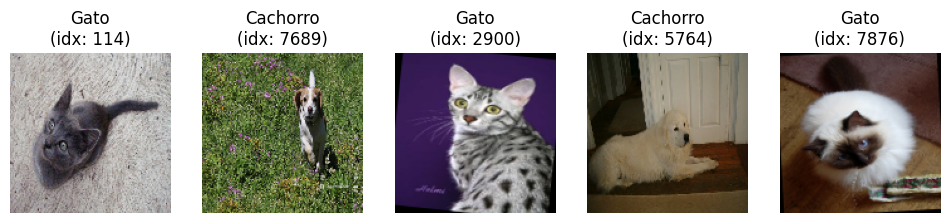

In [8]:
def show_class_distribution(y_data, title="Distribuição"):
    y_series = pd.Series(y_data)
    counts = y_series.value_counts().sort_index()
    
    print(f"--- {title} ---")
    print(f"Contagem detalhada:\n{counts}")
    print("-" * 20)

def plot_samples(X_data, y_data, img_size, n=5):
    """Mostra algumas imagens aleatórias."""
    plt.figure(figsize=(12, 4))
    
    n = min(n, len(X_data))
    
    indices = np.random.randint(0, len(X_data), n)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        
        try:
            image = X_data[idx].reshape(img_size[0], img_size[1], 3)
            plt.imshow(image)
        except ValueError:
            try:
                image = X_data[idx].reshape(img_size[0], img_size[1])
                plt.imshow(image, cmap='gray')
            except ValueError:
                plt.text(0.5, 0.5, "Dados não\nsão imagem", ha='center')
                plt.axis("off")
                continue

        label = "Cachorro" if y_data[idx] == 1 else "Gato"
        
        plt.title(f"{label}\n(idx: {idx})")
        plt.axis("off")
    plt.show()

show_class_distribution(y_train_bal, "Contagem no Treino")
plot_samples(X_train_bal, y_train_bal, IMG_SIZE, n=5)

In [9]:
# Converter os targets booleanos para inteiros (0 e 1)
y_train_bal_dog = (y_train_bal == 1).astype(int)
y_test_dog = (y_test == 1).astype(int)

print("Configurando XGBoost com suporte a GPU (Sintaxe v2.0+)...")

xgb_clf = XGBClassifier(
    n_estimators=100,
    random_state=42,
    tree_method='hist',    # Mude de 'gpu_hist' para 'hist'
    device='cuda',         # Adicione esta linha para ativar a GPU
    eval_metric='logloss',
    use_label_encoder=False
)

Configurando XGBoost com suporte a GPU (Sintaxe v2.0+)...


In [10]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt

# --- 4. FUNÇÕES DE EXTRAÇÃO (HOG e LBP) ---

def extract_hog_features(X, img_size):
    features_list = []
    print(f"   > Extraindo HOG de {len(X)} imagens...")
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        # Parâmetros otimizados
        f = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        features_list.append(f)
    return np.array(features_list)

def extract_lbp_features(X, img_size, P=8, R=1):
    features_list = []
    print(f"   > Extraindo LBP de {len(X)} imagens...")
    n_bins = P + 2 
    for i in range(len(X)):
        img = X[i].reshape(img_size[0], img_size[1], 3)
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, P, R, method="uniform")
        # Histograma normalizado
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        features_list.append(hist)
    return np.array(features_list)

In [11]:
# --- 5. EXECUTANDO A EXTRAÇÃO PARALELA ---

print("\n3. Extraindo Features do TREINO (Balanceado)...")
X_train_hog = extract_hog_features(X_train_bal, IMG_SIZE)
X_train_lbp = extract_lbp_features(X_train_bal, IMG_SIZE)

print("\n4. Extraindo Features do TESTE (Original)...")
X_test_hog = extract_hog_features(X_test, IMG_SIZE)
X_test_lbp = extract_lbp_features(X_test, IMG_SIZE)


3. Extraindo Features do TREINO (Balanceado)...
   > Extraindo HOG de 7984 imagens...
   > Extraindo LBP de 7984 imagens...

4. Extraindo Features do TESTE (Original)...
   > Extraindo HOG de 1478 imagens...
   > Extraindo LBP de 1478 imagens...


In [12]:
# --- 6. FUSÃO DE FEATURES (CONCATENAÇÃO) ---
# Colamos o vetor LBP ao final do vetor HOG
print("\n5. Fundindo HOG + LBP...")
X_train_final = np.hstack((X_train_hog, X_train_lbp))
X_test_final  = np.hstack((X_test_hog, X_test_lbp))

print(f"   Shape Final Treino: {X_train_final.shape}")
print(f"   Shape Final Teste:  {X_test_final.shape}")


5. Fundindo HOG + LBP...
   Shape Final Treino: (7984, 8110)
   Shape Final Teste:  (1478, 8110)


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

print(f"Dimensão ANTES do LLE: {X_train_final.shape[1]} features")

# --- PASSO 7: NORMALIZAÇÃO (Crucial para LLE) ---
print("\n7. Normalizando dados (StandardScaler)...")
scaler = StandardScaler()
# Ajusta a escala com base no treino e aplica
X_train_scaled = scaler.fit_transform(X_train_final)
# Aplica a mesma escala no teste
X_test_scaled = scaler.transform(X_test_final)

Dimensão ANTES do LLE: 8110 features

7. Normalizando dados (StandardScaler)...


In [14]:
# --- PASSO 8: LLE (Redução de Dimensionalidade) ---
print("8. Aplicando LLE (Isso pode demorar)...")

# n_components=50: Tenta resumir tudo em 50 números
lle = LocallyLinearEmbedding(n_components=50, n_neighbors=15, random_state=42, n_jobs=-1)

start = time.time()
# Aprende a topologia no treino
X_train_lle = lle.fit_transform(X_train_scaled)
print(f"   LLE Treino concluído em {time.time() - start:.1f}s")

print("   Aplicando LLE no Teste...")
X_test_lle = lle.transform(X_test_scaled)

print(f"Dimensão DEPOIS do LLE: {X_train_lle.shape[1]} features")

8. Aplicando LLE (Isso pode demorar)...
   LLE Treino concluído em 47.3s
   Aplicando LLE no Teste...
Dimensão DEPOIS do LLE: 50 features


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:46:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [19:47:04] WARNING: /workspace/src/common/error_msg.cc:41: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:47:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/

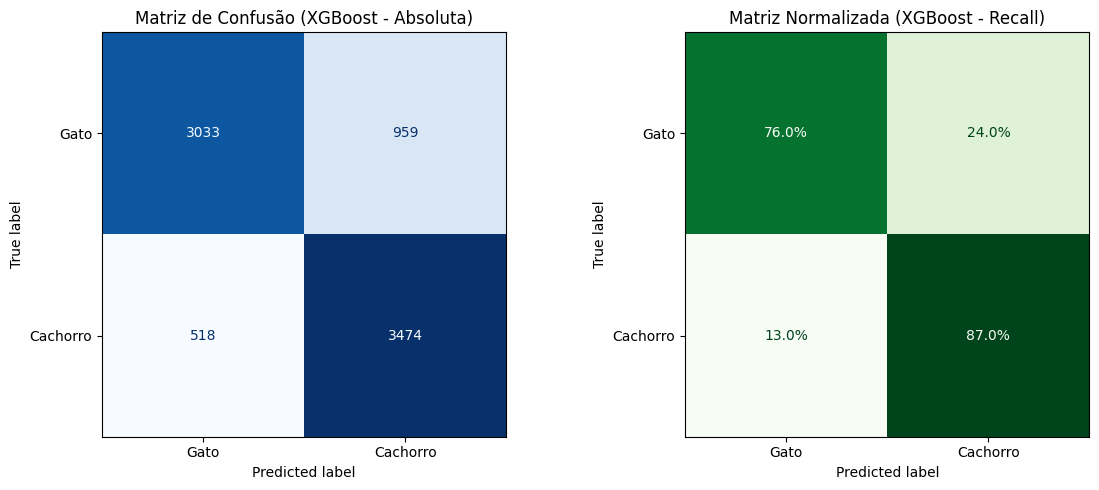

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Gera as predições via Cross-Validation usando XGBoost
# Nota: XGBoost é muito rápido, então o CV deve rodar bem mais depressa
y_train_pred_xgb = cross_val_predict(xgb_clf, X_train_final, y_train_bal_dog, cv=5)

# 2. Configura a plotagem
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Absoluta
ConfusionMatrixDisplay.from_predictions(
    y_train_bal_dog, 
    y_train_pred_xgb, 
    display_labels=["Gato", "Cachorro"], 
    values_format="d", 
    cmap="Blues", 
    ax=ax1,
    colorbar=False
)
ax1.set_title("Matriz de Confusão (XGBoost - Absoluta)")

# Gráfico 2: Normalizada
ConfusionMatrixDisplay.from_predictions(
    y_train_bal_dog, 
    y_train_pred_xgb, 
    display_labels=["Gato", "Cachorro"],
    normalize="true", 
    values_format=".1%", 
    cmap="Greens", 
    ax=ax2,
    colorbar=False
)
ax2.set_title("Matriz Normalizada (XGBoost - Recall)")

plt.tight_layout()
plt.show()

In [16]:
precision = precision_score(y_train_bal_dog, y_train_pred_xgb)
recall = recall_score(y_train_bal_dog, y_train_pred_xgb)
f1 = f1_score(y_train_bal_dog, y_train_pred_xgb)

print("Métricas de desempenho (XGBoost):\n")
print("Precisão: \t\t %.2f"%(precision))
print("Revocação: \t\t %.2f"%(recall))
print("F1-score: \t\t %.2f"%(f1))

Métricas de desempenho (XGBoost):

Precisão: 		 0.78
Revocação: 		 0.87
F1-score: 		 0.82


In [17]:
# method="predict_proba" funciona igual no XGBoost
y_probas_xgb = cross_val_predict(xgb_clf, X_train_final, y_train_bal_dog,
                                    cv=5, method="predict_proba")

y_scores_xgb = y_probas_xgb[:, 1]
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train_bal_dog, y_scores_xgb)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:48:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:48:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:49:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:49:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:49:58] WARNING: /w

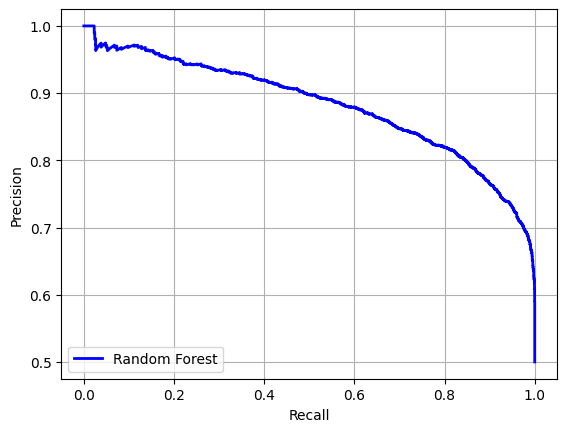

In [18]:
plt.plot(recalls_xgb, precisions_xgb, "b-", linewidth=2, label="Random Forest")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(loc="lower left")
plt.draw()

In [19]:
# cálculo da área sob a curva ROC (ROC AUC):
roc_auc = roc_auc_score(y_train_bal_dog, y_scores_xgb)
print("ROC AUC:%.4f"%roc_auc)

ROC AUC:0.8990


In [20]:
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_bal_dog, y_scores_xgb)


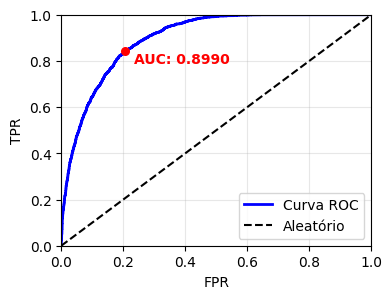

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_clean(y_true, y_scores):
    # 1. Cálculos
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)
    
    # 2. Encontrar o ponto de equilíbrio (Melhor balanço TPR vs FPR)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    
    plt.figure(figsize=(4, 3))
    
    # 3. Plota as linhas principais
    plt.plot(fpr, tpr, linewidth=2, label='Curva ROC', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
    
    # 4. Plota APENAS o ponto e o texto
    plt.scatter(optimal_fpr, optimal_tpr, color='red', s=30, zorder=5)
    
    # Adiciona o texto do AUC levemente deslocado para não ficar em cima da linha
    plt.text(
        optimal_fpr + 0.03, 
        optimal_tpr - 0.05, 
        f'AUC: {roc_auc:.4f}', 
        fontsize=10, 
        color='red',
        fontweight='bold'
    )

    # Configurações finais
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Chamada da função com seus dados
plot_roc_clean(y_train_bal_dog, y_scores_xgb)

In [22]:
# --- PASSO 9: TREINAMENTO FINAL COM XGBOOST ---
print("\n9. Treinando XGBoost Final (LLE Reduced)...")

xgb_lle = XGBClassifier(
    # --- Controle de Complexidade ---
    n_estimators=300,        # Mais árvores
    learning_rate=0.01,      # Aprendizado Lento (precisa de mais árvores)
    max_depth=2,             # Árvores rasas (evita decorar)
    min_child_weight=2,      # Poda árvores muito específicas
    gamma=0.1,               # Mínimo de ganho para dividir um nó
    
    # --- Imitando Random Forest (Aleatoriedade) ---
    subsample=0.8,           # Usa apenas 70% dos dados por árvore
    colsample_bytree=0.8,    # Usa apenas 60% das features por árvore
    
    # --- Penalidade Extra ---
    reg_alpha=0.01,          # Regularização L1 (Lasso)
    reg_lambda=1.0,          # Regularização L2 (Ridge)
    
    # --- Configuração Técnica ---
    tree_method='hist',      # Ou 'gpu_hist' se sua versão suportar
    device='cuda',
    eval_metric='logloss',
    random_state=42
)
# Treina nos dados reduzidos pelo LLE
xgb_lle.fit(X_train_lle, y_train_bal_dog)


9. Treinando XGBoost Final (LLE Reduced)...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

10. Avaliando...
              precision    recall  f1-score   support

        Gato       0.43      0.24      0.31       480
    Cachorro       0.70      0.85      0.77       998

    accuracy                           0.65      1478
   macro avg       0.56      0.54      0.54      1478
weighted avg       0.61      0.65      0.62      1478



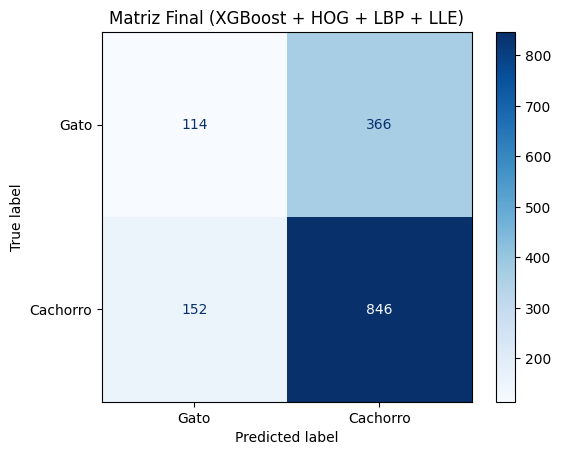

In [23]:
# --- PASSO 10: AVALIAÇÃO ---
print("10. Avaliando...")
# Predição no teste (lembre-se de usar X_test_lle)
y_pred_lle = xgb_lle.predict(X_test_lle)

print(classification_report(y_test_dog, y_pred_lle, target_names=["Gato", "Cachorro"]))

# Plota Matriz Final
ConfusionMatrixDisplay.from_predictions(
    y_test_dog, 
    y_pred_lle, 
    display_labels=["Gato", "Cachorro"], 
    cmap="Blues"
)
plt.title("Matriz Final (XGBoost + HOG + LBP + LLE)")
plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score

# CORREÇÃO: Usar a variável de predição do XGBoost (que definimos na célula anterior)
acc = accuracy_score(y_test_dog, y_pred_lle) 

print(f"=== RESULTADO FINAL NO TESTE (XGBoost) ===")
print(f"Acurácia Global: {acc:.2%}")

# Gera o relatório usando as predições do XGBoost
report = classification_report(y_test_dog, y_pred_lle, target_names=['Gato', 'Cachorro'])

print("Relatório de Classificação Detalhado:")
print(report)

=== RESULTADO FINAL NO TESTE (XGBoost) ===
Acurácia Global: 64.95%
Relatório de Classificação Detalhado:
              precision    recall  f1-score   support

        Gato       0.43      0.24      0.31       480
    Cachorro       0.70      0.85      0.77       998

    accuracy                           0.65      1478
   macro avg       0.56      0.54      0.54      1478
weighted avg       0.61      0.65      0.62      1478

